---------------------------------------------------------- START
device is cuda:0
---------------------------------------------------------- START:1
---------------------------------------------------------- START:2
---------------------------------------------------------- START:3
---------------------------------------------------------- START:4
---------------------------------------------------------- START:5
---------------------- PASSED LEARNER
---------------------------------------------------------- Before fit


epoch,train_loss,valid_loss,accuracy,time
0,3.207683,2.291498,0.085714,00:00


---------------------------------------------------------- After fit


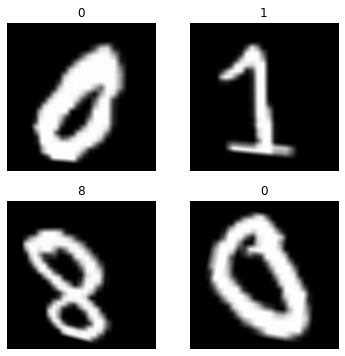

In [7]:
#%%
### %%heat
#import pdb
print("---------------------------------------------------------- START")
import torch
#import torch_xla.core.xla_model as xm

#tpu_device = xm.xla_device()
tpu_device = torch.device('cuda:0') #torch.cuda.device("cuda:0")#.current_device()
print(f"device is {tpu_device}")
print("---------------------------------------------------------- START:1")

from fastai2.vision.all import *
path = untar_data(URLs.MNIST)
datablock = DataBlock(
    blocks=(ImageBlock,CategoryBlock),
    get_items=get_image_files,
    get_y=parent_label,
    splitter=RandomSubsetSplitter(train_sz=0.001,valid_sz=0.001),#GrandparentSplitter(train_name='training',valid_name='testing'),
#    item_tfms=Resize(28),
    batch_tfms=aug_transforms(size=224)
)
print("---------------------------------------------------------- START:2")

#datablock.summary(path)

# %%
printed_device=0
printed_device2=0
NUM_PIXELS=3 # 1 single channedl 3 rgb
NUM_OUTPUTS=10 #2 for MNIST_TINY 10 MNIST
class Lenet2(nn.Module):
    """Lenet with layers"""
    def __init__(self):
        super(Lenet2, self).__init__()
        self.conv1 = nn.Conv2d(NUM_PIXELS, 6, 3) # set 3 for first item if RGB
        self.conv2 = nn.Conv2d(6, 16, 3)
        self.fc1 = nn.Linear(46656, 120) #(400, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, NUM_OUTPUTS) # Only 2 outputs (3 and 7) instead of 10
    def forward(self, x):
        global printed_device
        if x.device != tpu_device:
          print(f"************** ######################### EL DEVICE ES {tpu_device} no es {x.device} ######################### **************") if printed_device < 10 else noop
          printed_device += 1
        # Max pooling over a (2, 2) window
        x = F.max_pool2d(F.relu(self.conv1(x)), (2, 2))
        # If the size is a square you can only specify a single number
        x = F.max_pool2d(F.relu(self.conv2(x)), 2)
        x = x.view(-1, self.num_flat_features(x))
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

    def num_flat_features(self, x):
        size = x.size()[1:]  # all dimensions except the batch dimension
        num_features = 1
        for s in size:
            num_features *= s
        return num_features


print("---------------------------------------------------------- START:3")

# %%
dls_tpu = datablock.dataloaders(path,bs=4, device=tpu_device)
dls_tpu.vocab, dls_tpu.show_batch()

print("---------------------------------------------------------- START:4")

# %%
def print_local(msg):
  if False: return
  print(msg)

print("---------------------------------------------------------- START:5")

class XLAOptimProxy:
    def __init__(self,opt:Optimizer):
        #print("XLAOptimProxy#inicializando __init__")
        self.opt = opt

    def xla_step(self):
        #print("------------- xla optimizer!!!!!!!! BARRIER TRYE")
        #xm.optimizer_step(self.opt,barrier=True) # sync on gradient update
        self.opt.step()

    def __getattr__(self,name):
        if name == 'step': # override proxying for step method
            #print_local("calling xla_step")
            return getattr(self,'xla_step')
        # proxy everything else
        #print_local(f"calling XLAOptimProxy#{name}")
        return getattr(self.opt,name)


def sort_by_run(fs):
    end = L(fs).attrgot('toward_end')
    inp,res = L(fs)[~end] + L(fs)[end], L()
    while len(inp):
        for i,o in enumerate(inp):
            if _is_first(o, inp):
                res.append(inp.pop(i))
                break
        else: raise Exception("Impossible to sort")
    # TRACE: print(f"will invoke toward_end {res}")
    return res


print("---------------------- PASSED LEARNER")
################################################################33





from datetime import datetime

@patch_to(Learner)
def one_batch(self, i, b):
# TRACE:         print(f"{datetime.now().strftime(' (%H:%M:%S.%f)')}                   BATCH {i}")
        self.iter = i
        try:
            # TRACE: print(f"{datetime.now().strftime(' (%H:%M:%S.%f)')}                   SPLIT {i}")
            self._split(b);                                  self('begin_batch')
            # TRACE: print(f"{datetime.now().strftime(' (%H:%M:%S.%f)')}                 {i} called begin_batch")
            self.pred = self.model(*self.xb);                self('after_pred')
            # TRACE: print(f"{datetime.now().strftime(' (%H:%M:%S.%f)')}                 {i} called after_pred")
            if len(self.yb) == 0: return
            # TRACE: print(f"{datetime.now().strftime(' (%H:%M:%S.%f)')}                 {i} did not return becasue yb.length == 0")
            self.loss = self.loss_func(self.pred, *self.yb); self('after_loss')
            # TRACE: print(f"{datetime.now().strftime(' (%H:%M:%S.%f)')}                 {i} called after_loss")
            if not self.training: return
            # TRACE: print(f"{datetime.now().strftime(' (%H:%M:%S.%f)')}                 {i} did not return because we are training")
            self.loss.backward();                            self('after_backward')
            # TRACE: print(f"{datetime.now().strftime(' (%H:%M:%S.%f)')}                 {i} called after_backward")
            self.opt.step();                                 self('after_step')
            #xm.optimizer_step(self.opt,barrier=True);        self('after_step')
            # TRACE: print(f"{datetime.now().strftime(' (%H:%M:%S.%f)')}                 {i} called after_step")
            self.opt.zero_grad()
            # TRACE: print(f"{datetime.now().strftime(' (%H:%M:%S.%f)')}                 {i} called zero_grad!!!!!!!")
        except CancelBatchException:
            self('after_cancel_batch')
            # TRACE: print(f"{datetime.now().strftime(' (%H:%M:%S.%f)')}                 {i} called after_cancel_batch")
        finally:
            if False:
                # TRACE: print(f"{datetime.now().strftime(' (%H:%M:%S.%f)')}                 {i} AFTER BATCH NOT CALLED")
                # TRACE: print(f"{datetime.now().strftime(' (%H:%M:%S.%f)')}                 {i} AFTER BATCH NOT CALLED")
                # TRACE: print(f"{datetime.now().strftime(' (%H:%M:%S.%f)')}                 {i} AFTER BATCH NOT CALLED")
                # TRACE: print(f"{datetime.now().strftime(' (%H:%M:%S.%f)')}                 {i} AFTER BATCH NOT CALLED")
                print(f"{datetime.now().strftime(' (%H:%M:%S.%f)')}                 {i} AFTER BATCH NOT CALLED")
            else:
                # TRACE: print(f"{datetime.now().strftime(' (%H:%M:%S.%f)')}                 {i} WILL CALL after_batch")
                self('after_batch')
                # TRACE: print(f"{datetime.now().strftime(' (%H:%M:%S.%f)')}                 {i} called after_batch")





from torch.utils.data.dataloader import _MultiProcessingDataLoaderIter,_SingleProcessDataLoaderIter,_DatasetKind
_loaders = (_MultiProcessingDataLoaderIter,_SingleProcessDataLoaderIter)


@patch_to(DataLoader)
def __iter__(self):
        # TRACE: print(f"{datetime.now().strftime(' (%H:%M:%S.%f)')}  DataLoader#DataLoader#DataLoader#__iter__                         0")
        self.randomize()
        self.before_iter()
        # TRACE: print(f"{datetime.now().strftime(' (%H:%M:%S.%f)')}  DataLoader#DataLoader#DataLoader#__iter__ START FOR               1")
        for b in _loaders[self.fake_l.num_workers==0](self.fake_l):
            if self.device is not None:
                # TRACE: print(f"{datetime.now().strftime(' (%H:%M:%S.%f)')}  DataLoader#DataLoader#DataLoader#iterator to device from {b[0].device} y {b[1].device} to {self.device}")
                b = to_device(b, self.device)
                # TRACE: print(f"{datetime.now().strftime(' (%H:%M:%S.%f)')}  DataLoader#DataLoader#DataLoader#iterator to done!!!!")
            # TRACE: print(f"{datetime.now().strftime(' (%H:%M:%S.%f)')}  DataLoader#DataLoader#DataLoader#yielding                    3!!!! yield self.after_batch({b[0].device}) len of b is {len(b)}")
            yield self.after_batch(b)
            # TRACE: print(f"{datetime.now().strftime(' (%H:%M:%S.%f)')}  DataLoader#DataLoader#DataLoader#yielding                    4!!!!")
        # TRACE: print(f"{datetime.now().strftime(' (%H:%M:%S.%f)')}  DataLoader#DataLoader#DataLoader#__iter__ END FOR                 2")
        self.after_iter()
        # TRACE: print(f"{datetime.now().strftime(' (%H:%M:%S.%f)')}   DataLoader#DataLoader#DataLoader#__iter__ after ITER")
        if hasattr(self, 'it'): delattr(self, 'it')
        # TRACE: print(f"{datetime.now().strftime(' (%H:%M:%S.%f)')}     DataLoader#DataLoader#DataLoader#END __iter__")



@patch_to(Learner)
def all_batches(self):
        # TRACE: print("                                          Learner#ALL_BATCHES")
        self.n_iter = len(self.dl)
        for o in enumerate(self.dl):
            # TRACE: print("                                          Learner#ALL_BATCHES CALL ENTER")
            self.one_batch(*o)
            # TRACE: print("=======================================================================")
            # TRACE: print("=======================================================================")
            # TRACE: print("=======================================================================")
            # TRACE: print("                                          Learner#ALL_BATCHES CALL EXIT")
            # TRACE: print("=======================================================================")
            # TRACE: print("=======================================================================")
            # TRACE: print("=======================================================================")
        





@patch_to(Learner)
def create_opt(self):
        ooo = self.opt_func(self.splitter(self.model), lr=self.lr)
        prox = ooo #XLAOptimProxy(ooo)
        self.opt = prox
        if not self.wd_bn_bias:
            for p in self._bn_bias_state(True ): p['do_wd'] = False
        if self.train_bn:
            for p in self._bn_bias_state(False): p['force_train'] = True

proxyLearn = Learner(dls_tpu, Lenet2(), metrics=accuracy, opt_func=Adam)#, cbs=CallbackXLA)



print("---------------------------------------------------------- Before fit")
proxyLearn.fit(1, 10e-3) # 0.05) NOTE: Im not sure if this works...!!! it is now 96!
print("---------------------------------------------------------- After fit")

#%%

# %%


In [2]:
proxyLearn.fit(1, 10e-3) # 0.05) NOTE: Im not sure if this works...!!! it is now 96!


epoch,train_loss,valid_loss,accuracy,time
0,2.292306,2.306324,0.114286,00:00


SuggestedLRs(lr_min=0.010000000149011612, lr_steep=1.5848932266235352)

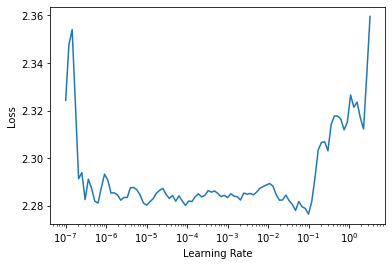

In [3]:
proxyLearn.lr_find()

In [4]:
proxyLearn.fit(1, 10e-1) # 0.05) NOTE: Im not sure if this works...!!! it is now 96!


epoch,train_loss,valid_loss,accuracy,time
0,2.726895,2.435543,0.057143,00:00


In [6]:
proxyLearn.fit(100, 10e-3) # 0.05) NOTE: Im not sure if this works...!!! it is now 96!


epoch,train_loss,valid_loss,accuracy,time
0,2.281509,2.342726,0.114286,00:00
1,2.266071,2.339744,0.114286,00:00
2,2.263660,2.345299,0.114286,00:00
3,2.263877,2.345670,0.114286,00:00
4,2.266414,2.347923,0.114286,00:00
5,2.265782,2.351070,0.114286,00:00
6,2.263395,2.349560,0.114286,00:00
7,2.260002,2.350568,0.114286,00:00
8,2.261366,2.348365,0.114286,00:00
9,2.262599,2.350521,0.114286,00:00


KeyboardInterrupt: 